In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [3]:
import matplotlib as mlp

plt.style.use('dark_background')

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

In [54]:
df = pd.read_csv('../victor/df_cow_latest.csv')

df.head()

,Номер лактации,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result,stage
0,6,3,62,291,213,МВ,3472,0,0,0,0,0,ТРАВМА,0
1,6,3,62,291,215,ТМ6,3474,0,0,1,1,2,ТЯЖЕЛОЕ,1
2,6,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА,2
3,7,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ,0
4,7,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ,1


In [55]:
# Название колонки - англ, в лямбде - русский
df['KM'] = df.protokol.str[:2].apply(lambda x: x == 'КМ').astype(int)

df.head()

,Номер лактации,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result,stage,KM
0,6,3,62,291,213,МВ,3472,0,0,0,0,0,ТРАВМА,0,0
1,6,3,62,291,215,ТМ6,3474,0,0,1,1,2,ТЯЖЕЛОЕ,1,0
2,6,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА,2,1
3,7,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ,0,1
4,7,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ,1,1


In [56]:
df = df[df.KM == 1]

df.protokol.value_counts()

КМ1    1917
КМ3    1054
КМ5    1031
КМ4     732
КМ2     510
КМ6     431
КМ7      41
КМ8      20
Name: protokol, dtype: int64

In [57]:
df_km = df.copy().reset_index().drop('index', axis=1)
df_km['version_km'] = df_km.protokol.apply(lambda x: x[-1]).astype(int)

df_km.head()

,Номер лактации,Легкость отела,Дней в сухостое предыдущей лактации,Дней стельности при событии,Дни доения при событии,protokol,age,p1,p2,p3,p4,struck,result,stage,KM,version_km
0,6,3,62,291,221,КМ4,3480,1,0,1,1,3,ЗДОРОВА,2,1,4
1,7,1,60,0,294,КМ5,3541,0,1,0,0,1,БОЛЕЕТ,0,1,5
2,7,1,60,0,302,КМ4,3549,0,1,0,0,1,ТЯЖЕЛОЕ,1,1,4
3,7,1,60,0,310,КМ5,3557,0,1,0,0,1,ТЯЖЕЛОЕ,2,1,5
4,7,1,60,0,324,КМ5,3571,0,1,0,1,2,ТЯЖЕЛОЕ,3,1,5


In [58]:
df_km.result.value_counts()

ТЯЖЕЛОЕ    2900
БОЛЕЕТ     2020
ЗДОРОВА     719
СРЕДНЕЕ      65
ТРАВМА       23
ЛЕГКОЕ        9
Name: result, dtype: int64

In [59]:
df_km['hard'] = (df_km.result == 'ТЯЖЕЛОЕ').astype(int)


df_km.hard.value_counts()

1    2900
0    2836
Name: hard, dtype: int64

In [60]:
df_km.groupby('version_km').hard.mean()

version_km
1    0.510172
2    0.496078
3    0.456357
4    0.528689
5    0.545102
6    0.491879
7    0.414634
8    0.500000
Name: hard, dtype: float64

In [61]:
df_km.groupby('version_km').hard.count()

version_km
1    1917
2     510
3    1054
4     732
5    1031
6     431
7      41
8      20
Name: hard, dtype: int64

In [83]:
from math import factorial
from itertools import combinations
from statsmodels.stats.weightstats import ztest


def multiple_comparisons(col, data, y='version_km', a=0.05):
    p_values = []

    for i, tup in enumerate(combinations(sorted(data[y].unique()), 2)):
        p_values.append(
            ztest(data[data[y] == tup[0]][col], \
                         data[data[y] == tup[1]][col])[1]
        )
        
    p_values.sort()
    
#     print(p_values)
    
    
    if data[y].nunique() < 2: return "Not enough samples"
    
    m = factorial(data[y].nunique()) / (factorial(data[y].nunique() - 2) * 2)
    
    stat_diff = 0
    pairs_diff = []
    
    for i, pval in enumerate(p_values):
        if pval < a / (m - i):
            stat_diff += 1
        else: 
            return stat_diff
        
    return stat_diff

In [84]:
for i in range(23):
    print(f'Stage {i}:\t', multiple_comparisons('hard', df_km[df_km.stage == i]))

Stage 0:	 0
Stage 1:	 2
Stage 2:	 0
Stage 3:	 0
Stage 4:	 0
Stage 5:	 0
Stage 6:	 1
Stage 7:	 0
Stage 8:	 1
Stage 9:	 0
Stage 10:	 0
Stage 11:	 0
Stage 12:	 0
Stage 13:	 0
Stage 14:	 2
Stage 15:	 0
Stage 16:	 0
Stage 17:	 0
Stage 18:	 0
Stage 19:	 Not enough samples
Stage 20:	 Not enough samples
Stage 21:	 Not enough samples
Stage 22:	 Not enough samples


In [ ]:
df_km.hard.value_counts()

Это единственное различие есть между КМ1 и КМ3

In [73]:
ztest(df_km[df_km.version_km == 1].hard, df_km[df_km.version_km == 3].hard)[1]

0.004953154050226471

Также отдельно сравним 4 и 5 протоколы лечения со всеми остальными

In [117]:
def compare_all(prot):
    pvalues = []
    
    for i in range(1, 9):
        if i != prot:
            pvalues.append(
                (i, ztest(df_km[df_km.version_km == i].hard
                       , df_km[df_km.version_km == prot].hard)[1].round(4))
            )
    
    return pvalues

In [119]:
compare_all(4)

[(1, 0.3939),
 (2, 0.2581),
 (3, 0.0026),
 (5, 0.4959),
 (6, 0.2252),
 (7, 0.1548),
 (8, 0.8001)]

In [120]:
compare_all(5)

[(1, 0.0701),
 (2, 0.0695),
 (3, 0.0),
 (4, 0.4959),
 (6, 0.0629),
 (7, 0.1001),
 (8, 0.6886)]

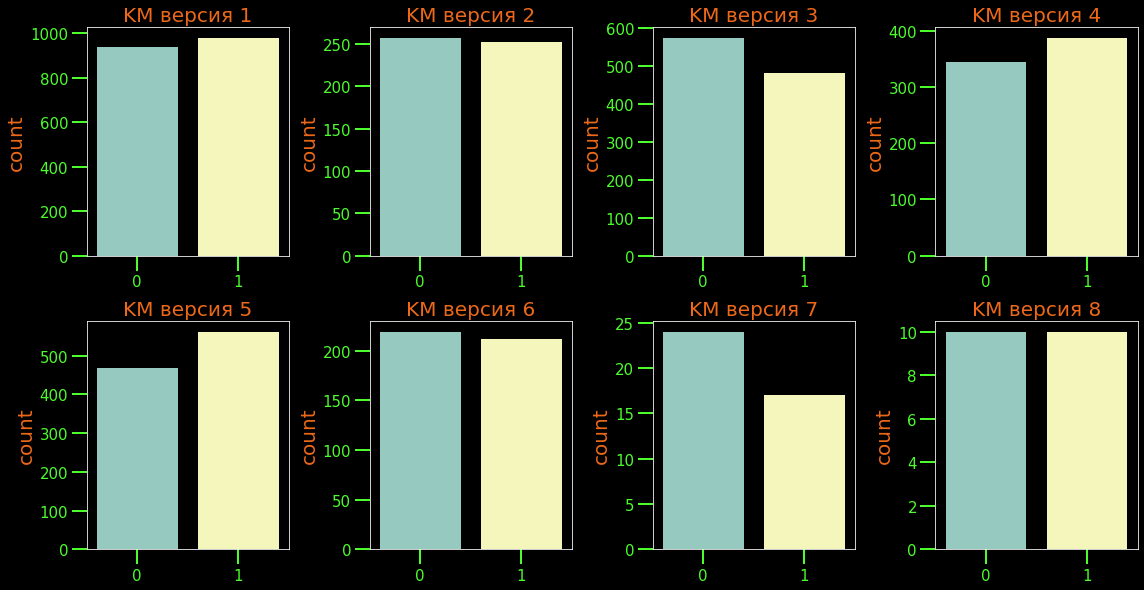

In [110]:
fig = plt.figure(figsize=(16, 16))

for i in range(1, 9):
    fig.add_subplot(4, 4, i)
    sns.countplot(df_km[df_km.version_km == i].hard)
    plt.title(f'KM версия {i}')
    plt.xlabel('')
    
fig.tight_layout()
plt.show()

In [99]:
sns.countplot(df_km.version_km, df_km.hard)

plt.show()

ValueError: Cannot pass values for both `x` and `y`

С применением множественной поправки 4 протокол `КМ` также будет отличаться от 3 протокола

In [ ]:
ztest

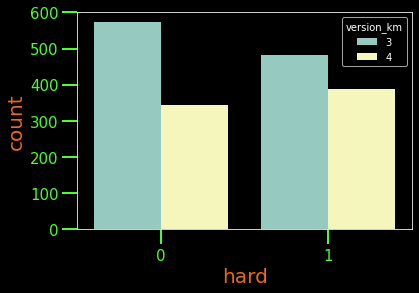

In [86]:
vals = df_km[df_km.version_km.isin([3, 4])]

sns.countplot(vals.hard, hue=vals.version_km)

plt.show()

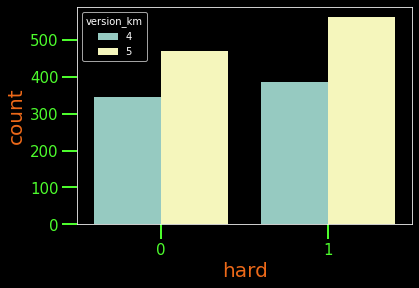

In [89]:
vals = df_km[df_km.version_km.isin([4, 5])]


sns.countplot(vals.hard, hue=vals.version_km)

plt.show()

In [91]:
ztest(
    df_km[df_km.version_km == 3].hard, vals[vals.version_km == 5].hard
)

(-4.066112784415759, 4.780380774973058e-05)